In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import warnings
import re
import string
import random


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords

from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')


import dataset


In [3]:
df = pd.read_csv(r'C:\Users\bchal\OneDrive\Documents\stage ai\task 4\twitter_training.csv')

In [4]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
print(f'The shape of the dataset is : {df.shape}')

The shape of the dataset is : (74681, 4)


In [6]:
print(f'The columns are :{df.columns}')


The columns are :Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')


In [7]:
print(f'The dtypes of the dataset : \n\n{df.dtypes}')

The dtypes of the dataset : 

2401                                                      int64
Borderlands                                              object
Positive                                                 object
im getting on borderlands and i will murder you all ,    object
dtype: object


In [8]:
df.describe(include='all')

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,TomClancysRainbowSix,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


EDA

In [9]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values , 
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.000000,0.000000,0.000000,686.000000
Missed_Values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036154,0.036154,0.036154,0.036154


In [10]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


 Here we change the name of columns to appropriate names:
'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Mode' , "im getting on borderlands and i will murder you all ,": 'Text'

In [11]:
df.rename(columns={'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Mode' 
                   , "im getting on borderlands and i will murder you all ,": 'Text'}, inplace=True)
df.columns

Index(['Index', 'Land', 'Mode', 'Text'], dtype='object')

 Here , we check Lands column , the number of unique values which is 32 and its names * And show the number of each values by dataframe and a Barchart

In [12]:
print(f'The number of unique lands : {len(df.Land.unique())}')
print('**' * 40)
df.Land.unique()

The number of unique lands : 32
********************************************************************************


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [13]:
lands =df.Land.value_counts()
lands.to_frame()

,count
Land,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


* We can see that distribution is quite the same for each area .
* between the range 2150 to 2328 changeably * Now we just show 10 of the hihest ones

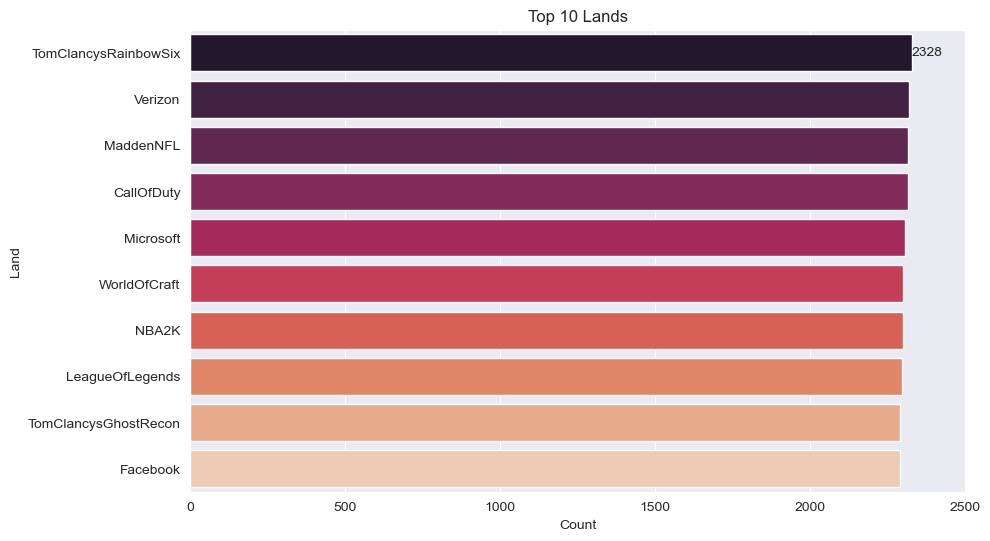

In [14]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
bar = sns.barplot(x=lands.values[:10] ,y=lands.index[:10] , palette='rocket')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0 , 2500)
plt.show()

* column Mode , which consists of 4 modes as : Positive ,Neutral ,Negative and Irrelevant
Negative with highest common reviws : 21698
Positive the second : 19712
Neutral the third : 17708
Irrelevant : 12537
* Lets depict the values by a pie chart

In [15]:
print(f'The unique values of Mode : {len(df.Mode.unique())}')
print('**' * 20)
print(df.Mode.unique())
mode = df.Mode.value_counts()
mode.to_frame().T

The unique values of Mode : 4
****************************************
['Positive' 'Neutral' 'Negative' 'Irrelevant']


Mode,Negative,Positive,Neutral,Irrelevant
count,21698,19712,17708,12537


Negative : 30.3 %
Positive : 27.5%
Neutral : 24.7%
Irrelevant : 17.5%

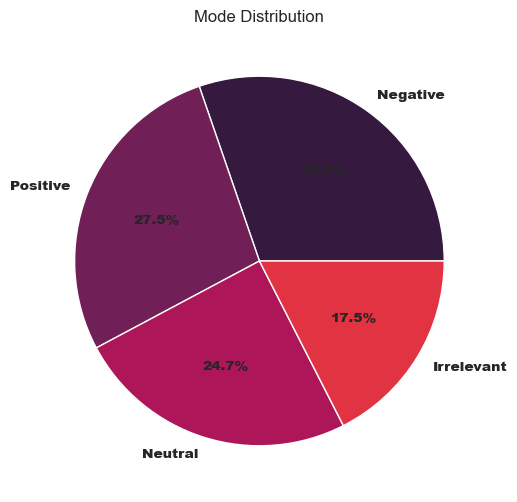

In [16]:
plt.figure(figsize=(6,6))
plt.pie(x = mode.values , labels=mode.keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"},colors=sns.color_palette("rocket"))
plt.title('Mode Distribution') 
plt.show()

* we can also take a look at each land with its mode and scan them :
Irrelevant : Battlefield has highest with 907 , TomClancysGhostRecon with 92 Lowest
Negative : MaddenNFL has highest with 1665 , RedDeadRedemption(RDR) with 290 Lowest
Neutral : Amazon has highest with 1197 , AssassinsCreed with 153 Lowest
Positive : AssassinsCreed has highest with 1382 , Facebook with 154 Lowest

In [17]:
pd.crosstab(df.Mode , df.Land).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='BuGn')

Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,971
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


* Here with re library we can replace a number of grammatically problems , verbal expressions , ...
* However we can deal with various emojis which are used from people to show off their emotion about the post(replace or delete them)
* Needless to say , emojis can play important role in determining the class in the views
* in the last part of text_clear function we have replaced more than 1 punctuations(those we have allowed to be) to just 1
* Finally , all texts become lower mode and instead more than 1 space be just 1 space

In [18]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', tx)
def text_cleaner(tx):
    
    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text


* Now , before replacing all dataset , I want to go through a copule of common methods which are familiar in NLP
for that I need to have a random example from dataset which I am using of random.choice to get one sample and clean with the function

In [19]:
random.seed(99)
test_text =text_cleaner( random.choice(df['Text']))
test_text = clean_emoji(test_text)
test_text

'ghost of tsushima is now graphically the best open world. red dead redemption 2 is one second ahead.'

POS or Part Of Speech , the part of speech indicates how the word functions in meaning as well as grammatically within the sentence.
There are 8 parts in English (noun, pronoun, verb, adjective, adverb, preposition, conjunction, and interjection)
Understanding parts of speech is essential for determining the correct definition of a word when using the dictionary.
* with using of Spacy library and its amazing features (nlp = spacy.load("en_core_web_sm")) which is used for English language
I am going to show you POS in the particular sample

In [20]:
doc = nlp(test_text)
for token in doc :
    print(f'{token} => {token.pos_}')

ghost => NOUN
of => ADP
tsushima => PROPN
is => AUX
now => ADV
graphically => ADV
the => DET
best => ADV
open => ADJ
world => NOUN
. => PUNCT
red => ADJ
dead => ADJ
redemption => NOUN
2 => NUM
is => AUX
one => NUM
second => ADJ
ahead => ADV
. => PUNCT



* NER or Named Entity Recognition , identifies, categorizes and extracts(named entities in text) the most important pieces of information from
unstructured text without requiring time-consuming human analysis. It's particularly useful for quickly extracting key information from large
amounts of data because it automates the extraction process
Furthermore , Named entities are specific terms that represent real-world objects, such as people, organizations, locations, and dates.
* like the previous exmple and spacy library features Im showing NER on our sample

In [21]:
doc = nlp(test_text)
for chunk in doc.ents:
    print(f'{chunk} => {chunk.label_}')

tsushima => GPE
2 => CARDINAL
second => ORDINAL


**Chunking:**
Converting a text to a smaller peices for having better undrestanding or the process of grouping similar words together based on
the nature of the word.
* Noun Groups, Verbs, verb groups, etc.
* NP stands for : Noun Chunks
* VP : Verp Chunks

In [22]:
doc = nlp(test_text)
for chunk in doc.noun_chunks:
    print(f'{chunk} => {chunk.label_}')


ghost => NP
tsushima => NP
the best open world => NP
red dead redemption => NP


* **Tokenization :**
* Tokenization is breaking text into smaller parts for easier machine analysis, helping machines understand human language.
These smaller parts known as tokens
Note :
There are various types of tokenizations such as : RegexpTokenizaton , TweetTokenization and etc...
which each one has different method for breaking a text into tokens
* **Description**
* Here we are using Regexp tokenization which splits a string into substrings using a regular expression. base on space

In [23]:
# Tokenizer = TweetTokenizer()
Tokenizer=RegexpTokenizer(r'\w+')
test_text_tokenized = Tokenizer.tokenize(test_text)
test_text_tokenized

# df['Text']=df['Text'].apply(lambda x : Tokenizer.tokenize(x))

['ghost',
 'of',
 'tsushima',
 'is',
 'now',
 'graphically',
 'the',
 'best',
 'open',
 'world',
 'red',
 'dead',
 'redemption',
 '2',
 'is',
 'one',
 'second',
 'ahead']

**CountVectorizer:**
Count Vectorizer is used to convert documents, text into vectors of term or token counts, it involves counting the number of occurences of words
appears in a document.For example , in our sentence we can see that is has come 2 times and other words have come just once.So,there will be a
vector which depicts the number of times which each word comes in the sentence.For better understanding , Im going to show in a heatmap chart.

array([[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

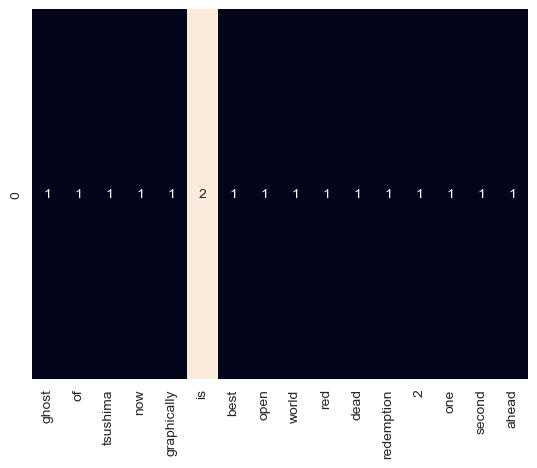

In [24]:
words  = ['ghost','of','tsushima','now','graphically','is','best','open','world','red','dead','redemption','2','one','second','ahead']
counter_vectorizer = CountVectorizer()
transform = counter_vectorizer.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words, 
        cbar=False)
transform

**TF-IDF:**
Tf_IDF : Actually , TF-IDF is composed of two parts.Firtsly , Tf which stands for Term Frequancy is how many times a word appears in a document.
(counting the number of words and divide it to the number of all words in the sentence)
IDF : which stands for Inverse Document Frequancy , is how common a word is found in a corpus or how uncommon a word is found in a corpus.
(measure of how important a term is across all documents in the corpus)
Result is actually a number between 0 and 1 , It is calculated by taking the logarithm of the total number of documents in the corpus divided
by number the of documents in which the term appears
However , it can not be a perfect manner to show just a single example to describe TF-IDF , but I will show it for better understanding

array([[0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.45883147, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.22941573]])

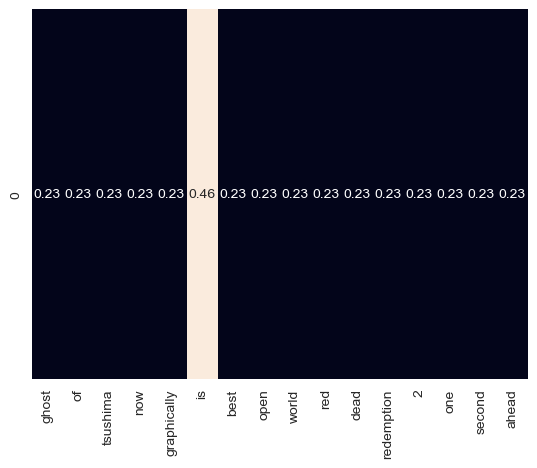

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
words  = ['ghost','of','tsushima','now','graphically','is','best','open','world','red','dead','redemption','2','one','second','ahead']
TF_IDF = TfidfVectorizer()
transform = TF_IDF.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words, 
        cbar=False)
transform

**N-grams:**
In a nutshell , N-gram means a sequence of N words.a collection of n successive items in a text document that may include words, numbers, symbols,
and punctuation.If 2 , it is based on just the word and the next word after that.3 grams , itself and with 2 words after that and so on.

In [26]:
def n_grams(text, n):

    return [text[i:i+n] for i in range(len(text)-n+1)]
cleaned = test_text_tokenized
n_grams(cleaned, 3)

[['ghost', 'of', 'tsushima'],
 ['of', 'tsushima', 'is'],
 ['tsushima', 'is', 'now'],
 ['is', 'now', 'graphically'],
 ['now', 'graphically', 'the'],
 ['graphically', 'the', 'best'],
 ['the', 'best', 'open'],
 ['best', 'open', 'world'],
 ['open', 'world', 'red'],
 ['world', 'red', 'dead'],
 ['red', 'dead', 'redemption'],
 ['dead', 'redemption', '2'],
 ['redemption', '2', 'is'],
 ['2', 'is', 'one'],
 ['is', 'one', 'second'],
 ['one', 'second', 'ahead']]

**Stop words:**
Stop words are words which are very common in a language. In many projects , they are deleted because they can not affect and they
can easily increase the volume of texts without any assistance.
Actually , there is a package which contains all stopwords(in NLTK library) in English which are commonly used for NLP projects.
First we have to determine our language and download the words for that language.
As you can see , there are 179 stopwords in English and I have shown 20 of them .

In [27]:
# Load stop words
stopwords_list = stopwords.words('english')

print(f'There are {len(stopwords_list)} stop words in the English language.')
print('**' * 20, '\n20 of them are as follows:\n')

# Display the first 20 stop words
for idx, value in enumerate(stopwords_list[:20]):
    print(f'{idx + 1}: {value}')

There are 179 stop words in the English language.
**************************************** 
20 of them are as follows:

1: i
2: me
3: my
4: myself
5: we
6: our
7: ours
8: ourselves
9: you
10: you're
11: you've
12: you'll
13: you'd
14: your
15: yours
16: yourself
17: yourselves
18: he
19: him
20: his


**Punctuation count**
* Now I want to show what punctuations are mostly used in each Mode of views.First, I create a function to read words of each sample for each
Mode and then using defaultdict to count each stop words which exists in the whole samples.Using sorted to adjust them with highest one to lowest
(for 10 most commons , I have used Bar chart to depict)
You can see that , (the , to , and , a) are come the same amount in each Mode with same distribution respectively .

In [28]:
def make_corpus(kind):
    corpus = []
    for text in df.loc[df['Mode']==kind]['Text'].str.split():
        for word in text:
            corpus.append(word)
    return corpus    

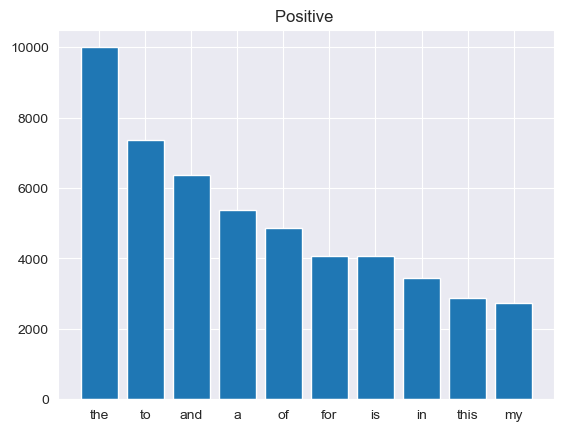

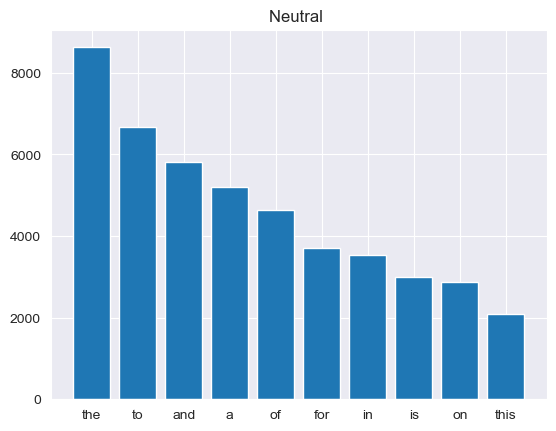

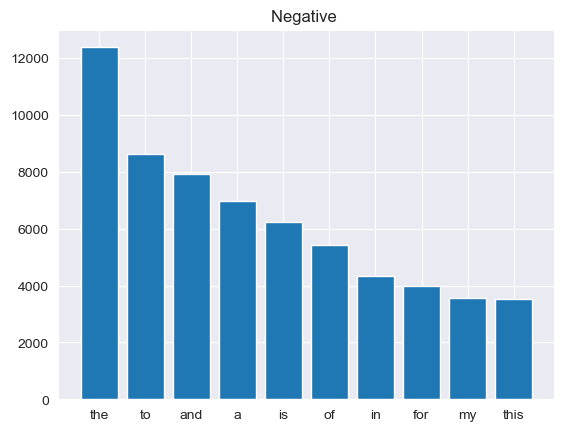

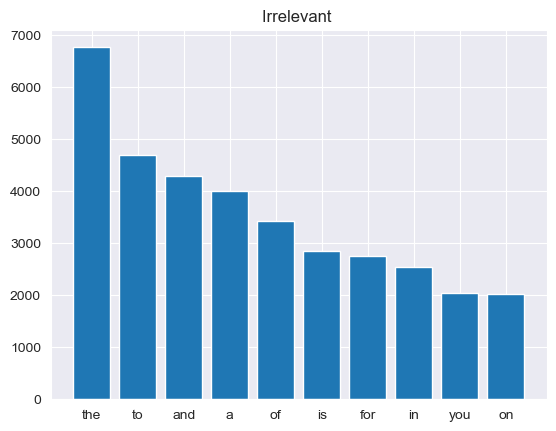

CPU times: total: 3.08 s
Wall time: 3.43 s


In [29]:
%%time
stop = stopwords.words('english')
sentiments = list(df.Mode.unique())

for inx , value in enumerate(sentiments):
    
    corpus = make_corpus(value)
    
    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1
    
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top)
    plt.title(f'{value} ')
    plt.bar(x , y)
    plt.show()

**Descripton**
* Here , I just do the previous techniques on the dataset to prepare them for the next steps.
* clear them with text_clearer , and tokenize them .

In [30]:
# df['Text'] = df['Text'].apply(lambda x : clean_emoji(x))
df['Text'] = df['Text'].apply(lambda x : text_cleaner(x))
df['Text']= df['Text'].apply(lambda x : Tokenizer.tokenize(x))
df['Text'].to_frame()

,Text
0,"[i, am, coming, to, the, borders, and, i, will..."
1,"[im, getting, on, borderlands, and, i, will, k..."
2,"[im, coming, on, borderlands, and, i, will, mu..."
3,"[im, getting, on, borderlands, 2, and, i, will..."
4,"[im, getting, into, borderlands, and, i, can, ..."
...,...
74676,"[just, realized, that, the, windows, partition..."
74677,"[just, realized, that, my, mac, window, partit..."
74678,"[just, realized, the, windows, partition, of, ..."
74679,"[just, realized, between, the, windows, partit..."


* **Lemmatization :**
Lemmatization is a text pre-processing technique used in natural language processing (NLP) models to break a word down to its root meaning to
identify similarities. For example, a lemmatization algorithm would reduce the word better to its root word, or lemme, good.
* **Stemming :**
Stemming is a natural language processing technique that is used to reduce words to their base form, also known as the root form.The word
after stemming is called stem of that word.
* **Difference :**
The most important different between Lemmatization and stemming is that , Lemmatization is more accurate and it brings a word to the
language root of that word and stemming can be anything which means for computer and is not readable for humans(sometimes not readable)
However , stemming is also faster and is a great way for huge corpus. 
* **Sample**:
In the example I have shown the lemma of each word **Dataset**
for the all dataset , we can afford either , which I have commented lemmatization method , if we want Lemmatization we can uncomment it and use
instead of stemming technique. 
***Note**
In the following code , before stemming , we are deleting all stopwords from each sample and then afford its stemmig for each word.

In [31]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(test_text)
for token in doc :
    print(f'{token} => {token.lemma_}')

ghost => ghost
of => of
tsushima => tsushima
is => be
now => now
graphically => graphically
the => the
best => well
open => open
world => world
. => .
red => red
dead => dead
redemption => redemption
2 => 2
is => be
one => one
second => second
ahead => ahead
. => .


In [32]:
# lemmatizer = WordNetLemmatizer() 
Stemmer = PorterStemmer()
def stopwords_cleaner(text):
#     word = [lemmatizer.lemmatize(letter) for letter in text if letter not in stopwords_list]
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    peasting = ' '.join(word)
    return peasting
df['Text'] = df['Text'].apply(lambda x : stopwords_cleaner(x))
# stopwords_cleaner(Tokenizer.tokenize(df.Text[100]))

In [33]:
df['Text'][:10].to_frame()


,Text
0,come border kill
1,im get borderland kill
2,im come borderland murder
3,im get borderland 2 murder
4,im get borderland murder
5,spent hour make someth fun know huge borderlan...
6,spent coupl hour someth fun know huge borderla...
7,spent hour someth fun know huge borderland fan...
8,spent hour make someth fun know huge rhandlerr...
9,2010 spent hour make someth fun know huge rhan...


* **WordCloud**
word Cloud is just a data visualization technique used for representing text data in which the size of each word indicates its frequency or
importance.Now , I will show the most important words(common ones) exclude stopwords for each Mode.

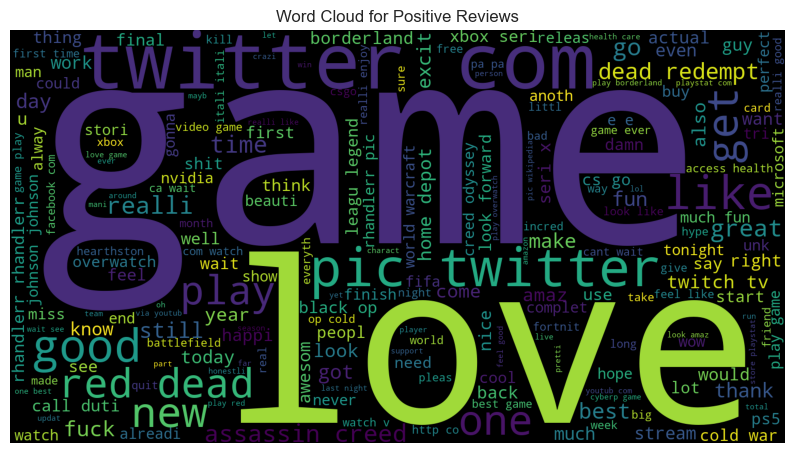

CPU times: total: 1.89 s
Wall time: 3.6 s


In [34]:
%%time
positive_reviews = df[df['Mode'] == 'Positive']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

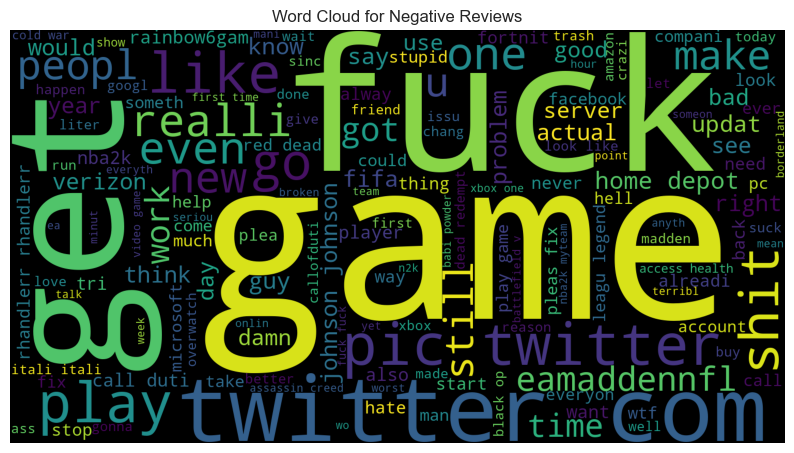

CPU times: total: 1.44 s
Wall time: 3.14 s


In [35]:
%%time
positive_reviews = df[df['Mode'] == 'Negative']['Text']
neg = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(neg)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

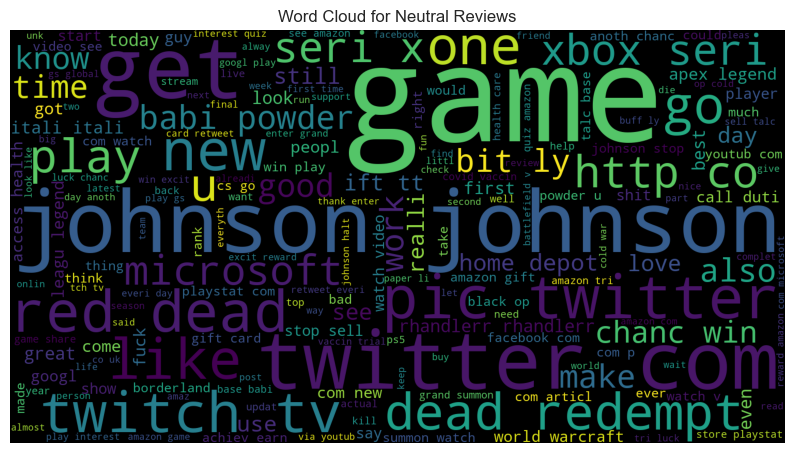

CPU times: total: 1.73 s
Wall time: 3.6 s


In [36]:
%%time
positive_reviews = df[df['Mode'] == 'Neutral']['Text']
Neutral = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Neutral)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Neutral Reviews')
plt.axis('off')
plt.show()

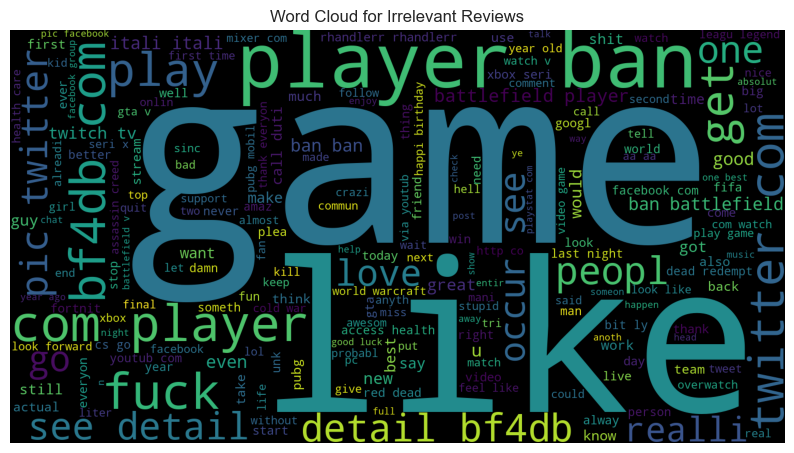

CPU times: total: 1.53 s
Wall time: 3.48 s


In [37]:
%%time
positive_reviews = df[df['Mode'] == 'Irrelevant']['Text']
Irrelevant  = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Irrelevant )
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Irrelevant Reviews')
plt.axis('off')
plt.show()

* **Descripton**
A number of fundamental statistics are shown below to know about corpus .such as , maximum , minimum length of texts ,
mean of length , std and the last calculation which is momentous is the number of words which we are required to have for each sample
we should not allow all words of each sample be in the review).For example, someone has a review with 797 words. so it is computiationally expensive and furthermore , it dosent allow our model to learn perfectly.Instead of all words , we are going to use a formula to keep 95% of data , but
with a samller amount of data for learning better and instead of those additional words we use a special character namely PAD becuase all sample
should have the same length. here , Mew + 2 sigma is 165.7 which we are going to use 166 words of each sample.

In [38]:
len_text = [len(tx) for tx in df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')

Max Length : 797
Min Length : 0
Mean Length : 67.68
Std Length : 49.01
Mew + 2sigma : 165.7


* **Descripton**
Now , after removing all stop words we want to see what words are most common for each mode in our corpus.Like wordcloud
but in a barchart to have better insights. (either wordcloud or this way is enough for representing)

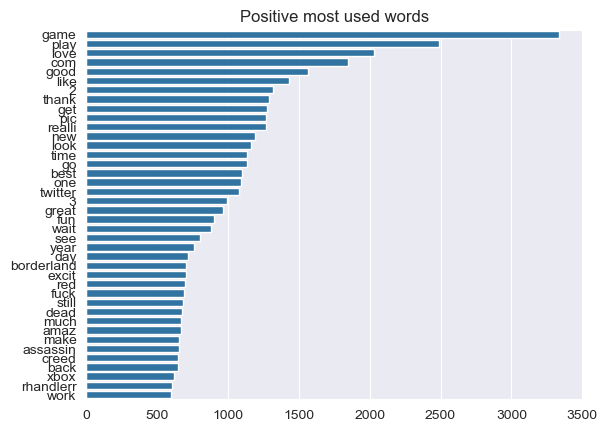

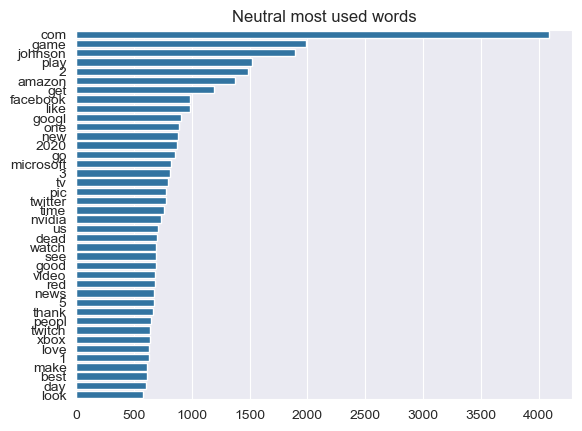

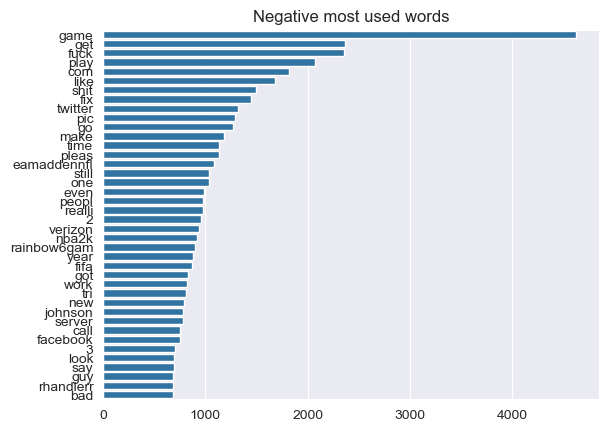

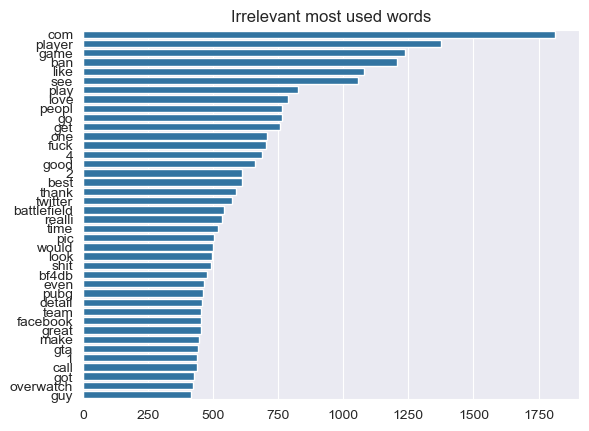

CPU times: total: 1.88 s
Wall time: 2.02 s


In [39]:
%%time
for inx , value in enumerate(sentiments):
    
    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
         if word not in stop:
            x.append(word)
            y.append(count)
         
    sns.barplot(x=y, y=x, orient='h')
    plt.title(f'{value} most used words')
    plt.show()

* **Descripton**
we are going to create a column namely sentiments and instead of Positive , Negative we put 1 and 0 , instead of Neutral and
Irrelevant we put 2. It means that underestanding Positive and Negative reviews is much more important for use rather that neutral and
Irrelevant ones.(Just for decreasing the calsses and increasing the accuracy for finding Positive and Negative ones) however , we are able to
classify each one of them without mixing , but of curse the accuracy will decrease noticeably.

In [40]:
df['sentiments'] = df['Mode'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })
df.sample(10)

,Index,Land,Mode,Text,sentiments
37473,5225,Hearthstone,Neutral,noth love made complex mostli mostli col fanta...,2
27708,1171,AssassinsCreed,Negative,sometim feel like old granni play game month a...,0
59828,3454,Facebook,Neutral,peopl keep ask gener public gay allow thing no...,2
12988,8631,NBA2K,Negative,know nba2k 2ktv feel like noth wrong nba2k kee...,0
71922,11120,TomClancysGhostRecon,Negative,ghostrecon could happen game releas long still...,0
4715,10,Amazon,Neutral,biohazzard thank enter grand summon watch vide...,2
31781,7456,LeagueOfLegends,Neutral,west bit hope good playoff finish slowli die g...,2
50395,6251,FIFA,Negative,even profession footbal dig ea ea see fuck eve...,0
73640,9015,Nvidia,Irrelevant,russian empleey ingam voic,2
37237,8386,Microsoft,Neutral,tok microsoft target love million peopl todayn...,2


**Descripton**
Now , we are going to create a customer class to show len and item.

In [41]:
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

* **Descripton**
We require helper functions to help us reading word vectors(we have a vord vector to give our model to understand the distant meaning of each words
and by that we can improve our model accuracy. There are many word vectors whcih I will use glove.6B.300d 300 is the dimention.you can use less
ones. More is better understanding but computationally higher.)and them another function to help us create embedding matrix for our corpus words.

In [42]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])
        
    return data
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
            
    return embedding_matrix

* Model

In [43]:
class sentimentBiLSTM(nn.Module):
#inherited from nn.Module
    
    def __init__(self, embedding_matrix, hidden_dim, output_size):
      
        #initializing the params by initialization method 
        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
        # craetinh embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)
        
        ## initializes the weights of the embedding layer to the pretrained embeddings in 
        ## embedding_matrix. It first converts embedding_matrix to a PyTorch tensor and 
        ## wraps it in an nn.Parameter object, which makes it a learnable parameter of the model.
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim,hidden_dim,bidirectional=True,batch_first=True)
                #it is multuplied by 2 becuase it is bi_directional if one-sided it didnt need.
        self.fc = nn.Linear(hidden_dim*2, output_size)
        

    #we need a forward function to model calculate the cost and know how bad the params is .  
    # However , it can be written in a line of code but if we want to track it it is easier way.  
    def forward(self, x):

       
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out[:, -1]
        out = self.fc(lstm_out)

        return out

* **Descripton**
spliting data to train and test => 80% for train and 20% for test

In [44]:
y = df.sentiments.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)

* Max_length as mew + 2sigma = 167
* Batch size is a number that detremined based on your system 16-32-64...
* Hidden_dimention for the model will be 64
* output is the number of classes which we have (len(classes))
* Also check if Cuda is available we put our system on GPU else CPU

In [45]:
MAX_LEN = 167
BATCH_SIZE = 32
hidden_dim = 64
output_size = 3


if torch.cuda.is_available():
    
       device = torch.device("cuda")
   
else:
       device = torch.device("cpu")
    

print(f'Current device is {device}')

Current device is cuda


**Descripton**
* now , we need to convert each sample to a readable way and deleting all extra words more than 167 and put PAD character instead
we use texts_to_sequences function to do that.and then using DataLoader to read data for both Train and Test.

In [46]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Text.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.Text.values)
xtest = tokenizer.texts_to_sequences(test_df.Text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiments.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.sentiments.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)
# check a batch of data 
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[    0,     0,     0,  ...,    19,   256,  1203],
         [    0,     0,     0,  ...,     0,    49, 17121],
         [    0,     0,     0,  ...,  2649,   100,    83],
         ...,
         [    0,     0,     0,  ...,    62,    26,  1569],
         [    0,     0,     0,  ...,    99,     9,  1100],
         [    0,     0,     0,  ...,     0,     0,   800]]),
 'target': tensor([1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1,
         1, 1, 0, 0, 2, 2, 0, 1])}

**Descripton**
* As I said , we need a word vector (glove.6B.300d) which Im using and now load it and tokenize it

In [47]:
embedding_dict = load_vectors(r'C:\Users\bchal\OneDrive\Documents\stage ai\task 4\glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

* **Descripton** :
Now create a object of the model (embedding_matrix, hidden_dim=64, output_size=3) and put the model on device.

In [48]:
model = sentimentBiLSTM(embedding_matrix ,  hidden_dim, output_size)
model = model.to(device)
print(model)

sentimentBiLSTM(
  (embedding): Embedding(23595, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


**Descripton**
* manual_seed : for reproductivity
* Optimizer : can be either SGD and Adam or any others . But I prefer Adam as defualt. with lr = 0.001
* cost_function = CrossEntropyLoss() cause we have 3 classes => BCELoss() if it was just 2
* schedul_learning: also we can use a schedul_learning to decrease the lr after a number of epochs but I tried and i didnt go well
* acc : acc function is used to show the accuray
* The number of epochs will be = 9

In [49]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss() 
# schedul_learning = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer , milestones=[6] ,
#                                                         gamma=0.055)

def acc(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label.squeeze()).item()

In [50]:
clip = 5
epochs = 9
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    # for getting loss and accuracy for train
    train_losses = []
    train_acc = 0.0

    #put model on train mode
    model.train()
    correct = 0

    # initialize hidden state 
    for data in train_loader:  

        #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

         #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)
          # calculate the loss and perform backprop
        loss = criterion(output, labels.long())
        loss.backward()
        train_losses.append(loss.item())
        # accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    # for getting loss and accuracy for valiadtion
    val_losses = []
    val_acc = 0.0

    #put model on evaluation mode
    model.eval()
    for data in valid_loader:
                #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

        #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)

        output = model(inputs)
        #Loss calculating 
        val_loss = criterion(output, labels.long())
        #append Loss to the above list
        val_losses.append(val_loss.item())

        # calculating accuracy 
        accuracy = acc(output,labels)
        val_acc += accuracy
        epoch_train_loss = np.mean(train_losses)

        #using schedule lr if you need
#         schedul_learning.step()
    #appending all accuracy and loss to the above lists and variables
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        #each time that model(params) get better you can save the model(you have to enter a path ou you pc and save with pt file)
        # torch.save(model.state_dict(), r'C:\Users\payama\Desktop\Projects kaggle\NLP\vectors features\BidirectionalLSTM.pt')
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        print(f'Validation loss decreased ({valid_loss_min} --> {epoch_val_loss})  Saving model ...')
        # save model if better result happends
        valid_loss_min = epoch_val_loss
    print(30 * '==' , '>')

Epoch 1
train_loss : 0.8643692748497346 val_loss : 0.7715718427493802
train_accuracy : 59.38524876142628 val_accuracy : 65.79443165166423
Validation loss decreased (inf --> 0.7715718427493802)  Saving model ...
============================================================ >
Epoch 2
train_loss : 0.6784266059888534 val_loss : 0.6546847340911294
train_accuracy : 70.47658921219734 val_accuracy : 71.9279882771614
Validation loss decreased (0.7715718427493802 --> 0.6546847340911294)  Saving model ...
============================================================ >
Epoch 3
train_loss : 0.5274055105041752 val_loss : 0.575514291823577
train_accuracy : 78.00397739166841 val_accuracy : 75.91933570581257
Validation loss decreased (0.6546847340911294 --> 0.575514291823577)  Saving model ...
============================================================ >
Epoch 4
train_loss : 0.41128691783801996 val_loss : 0.5290308138668137
train_accuracy : 83.25832112204313 val_accuracy : 79.3245412043821
Validation lo

**Descripton**
* The result after 10 epochs is :
* train_accuracy : 92.48482311073896
* val_accuracy : 82.98095038727234
* train_loss : 0.1850281291641815
* val_loss : 0.5166599419826362
* Lets plot it for better understanding =>

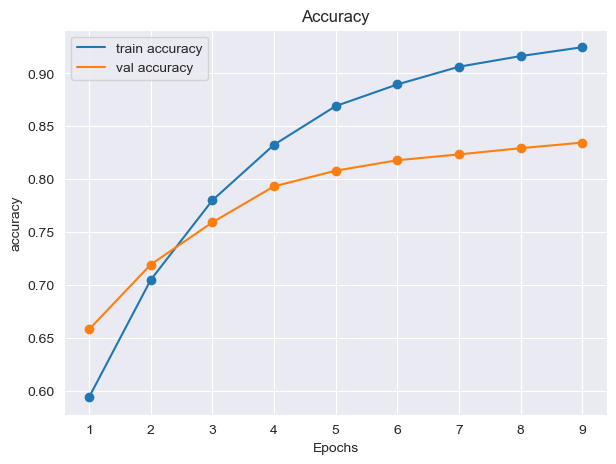

In [51]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_acc , label='train accuracy')
plt.scatter(range(1,10),epoch_tr_acc)
plt.plot(range(1,10),epoch_vl_acc , label='val accuracy')
plt.scatter(range(1,10),epoch_vl_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

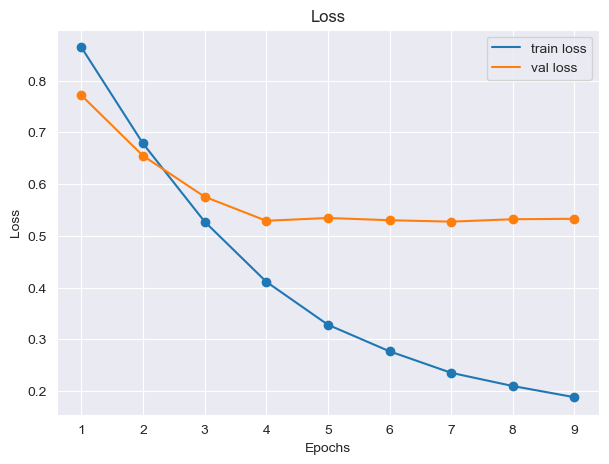

In [52]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_loss , label='train loss')
plt.scatter(range(1,10),epoch_tr_loss )
plt.plot(range(1,10),epoch_vl_loss , label='val loss')
plt.scatter(range(1,10),epoch_vl_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

LLM

In [53]:
from transformers import pipeline

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Example tweet
tweet = "I love how responsive customer service was today!"

# Perform classification
result = classifier(tweet, candidate_labels=sentiments)
print(result)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'sequence': 'I love how responsive customer service was today!', 'labels': ['Positive', 'Neutral', 'Negative', 'Irrelevant'], 'scores': [0.972460150718689, 0.019162144511938095, 0.005157278385013342, 0.0032203926239162683]}


Set Up the API Key

In [ ]:
from transformers import LlamaTokenizer, LlamaForSequenceClassification
import torch

# Update the model path to where your fine-tuned model is saved
model_path = 'openlm-research/open_llama_3b'  # Replace with the actual path if different
tokenizer = LlamaTokenizer.from_pretrained(model_path, legacy=False)
model = LlamaForSequenceClassification.from_pretrained(model_path)

# Set a padding token if it's not already defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define the label mapping used during training
label_mapping = {0: 'Positive', 1: 'Neutral', 2: 'Negative', 3: 'Irrelevant'}

# Define keywords to detect company
company_keywords = {
    'Facebook': ['Facebook', 'Meta'],
    'FIFA': ['FIFA', 'World Cup', 'football'],
    'NVIDIA': ['NVIDIA', 'GPU', 'graphics card'],
    # Add more companies and keywords as needed
}

def detect_company(text):
    """Detects the company mentioned in the text based on keywords."""
    for company, keywords in company_keywords.items():
        if any(keyword in text for keyword in keywords):
            return company
    return "Unknown"

def predict_sentiment_and_company(text):
    # Tokenize and encode the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding='max_length',
        max_length=64
    )

    # Move tensors to GPU if available
    device = torch.device("cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Run the model and get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the label with the highest score
    predicted_class = torch.argmax(logits, dim=1).item()
    sentiment = label_mapping[predicted_class]
    
    # Detect the company
    company = detect_company(text)
    
    return sentiment, company

# Test the model with example texts
test_text_1 = "FIFA's recent policies on fair play have received a lot of praise!"
sentiment, company = predict_sentiment_and_company(test_text_1)
print(f"Text: {test_text_1}\nSentiment: {sentiment}\nCompany: {company}\n")

test_text_2 = "Facebook is facing criticism over privacy concerns again."
sentiment, company = predict_sentiment_and_company(test_text_2)
print(f"Text: {test_text_2}\nSentiment: {sentiment}\nCompany: {company}\n")

test_text_3 = "NVIDIA's new graphics card is groundbreaking and fast!"
sentiment, company = predict_sentiment_and_company(test_text_3)
print(f"Text: {test_text_3}\nSentiment: {sentiment}\nCompany: {company}\n")


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text: FIFA's recent policies on fair play have received a lot of praise!
Sentiment: Neutral
Company: FIFA

Text: Facebook is facing criticism over privacy concerns again.
Sentiment: Positive
Company: Facebook

Text: NVIDIA's new graphics card is groundbreaking and fast!
Sentiment: Positive
Company: NVIDIA



In [4]:
def classify_sentiment(tweet):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant for sentiment analysis."},
            {"role": "user", "content": f"Classify the sentiment of this tweet as Positive, Negative, Neutral, or Mixed: '{tweet}'"}
        ]
    )
    # Extract the sentiment from the model's response
    sentiment = response['choices'][0]['message']['content']
    return sentiment.strip()
